In [1]:
from pathlib import Path
import pandas as pd
from dotenv import load_dotenv


def find_project_root(marker: str = ".env") -> Path:
    """Busca el archivo .env hacia arriba para fijar la raíz del proyecto."""
    current = Path().resolve()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent
    return current


ROOT_PATH = find_project_root()
load_dotenv(ROOT_PATH / ".env")


def get_data_path(relative_path: str | Path) -> str:
    """Retorna la ruta absoluta como str; usa *_sample si el archivo principal no existe."""
    path = Path(relative_path)
    if not path.is_absolute():
        path = ROOT_PATH / path

    if path.exists():
        return str(path)

    sample_path = path.with_name(path.stem + "_sample" + path.suffix)
    if sample_path.exists():
        print(f"⚠️ Usando muestra: {sample_path.name}")
        return str(sample_path)

    raise FileNotFoundError(f"No se encontró el archivo {path} ni su muestra {sample_path}")


print(f"✅ Raíz detectada: {ROOT_PATH}")

✅ Raíz detectada: /home/els4nchez/Videos/Harmeregildo


---

## 1️⃣ Importación de Librerías

In [2]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

# Estadística
from scipy import stats
from scipy.stats import jarque_bera

# Configuración
import warnings
warnings.filterwarnings('ignore')

# Configurar estilos de matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


---

## 2️⃣ Carga de Datos Procesados

In [3]:
# Configurar rutas del proyecto
BASE_DIR = ROOT_PATH
DATA_DIR = BASE_DIR / 'data'
UNIFICACION_DIR = BASE_DIR / 'unificacion'
DATA_PROCESADO_DIR = UNIFICACION_DIR / 'datos_procesados'
FIGURAS_DIR = UNIFICACION_DIR / 'figuras'

# Crear directorio de figuras si no existe
FIGURAS_DIR.mkdir(parents=True, exist_ok=True)

# Cargar datos procesados del notebook anterior
ruta_datos = get_data_path(DATA_PROCESADO_DIR / 'precios_oro_diario_limpio.csv')

# Cargar datos (la columna de fecha se llama 'UTC' en el archivo exportado)
df = pd.read_csv(ruta_datos, parse_dates=['UTC'], index_col='UTC')
df.index.name = 'Date'  # Renombrar índice a 'Date' por consistencia

print("✅ Datos cargados exitosamente")
print(f"\n📊 Dimensiones: {df.shape[0]:,} días x {df.shape[1]} variables")
print(f"   Rango temporal: {df.index.min().date()} → {df.index.max().date()}")
print(f"   Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✅ Datos cargados exitosamente

📊 Dimensiones: 3,614 días x 5 variables
   Rango temporal: 2016-01-03 → 2025-11-24
   Memoria: 0.17 MB


In [4]:
# Información general del dataset
print("📋 Información del Dataset:")
print("="*60)
df.info()

print("\n✅ Verificación de valores nulos:")
print(df.isnull().sum())

print("\n✅ Verificación de duplicados:")
print(f"Filas duplicadas: {df.duplicated().sum()}")

📋 Información del Dataset:
<class 'pandas.DataFrame'>
DatetimeIndex: 3614 entries, 2016-01-03 to 2025-11-24
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3614 non-null   float64
 1   High    3614 non-null   float64
 2   Low     3614 non-null   float64
 3   Close   3614 non-null   float64
 4   Volume  3614 non-null   float64
dtypes: float64(5)
memory usage: 169.4 KB

✅ Verificación de valores nulos:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

✅ Verificación de duplicados:
Filas duplicadas: 290


---

## 3️⃣ Estadísticas Descriptivas

Análisis univariado de cada variable (Open, High, Low, Close, Volume).

In [5]:
# Estadísticas descriptivas completas
print("📊 ESTADÍSTICAS DESCRIPTIVAS - Precios del Oro (USD/oz)")
print("="*70)

descriptive_stats = df.describe().T
descriptive_stats['rango'] = descriptive_stats['max'] - descriptive_stats['min']
descriptive_stats['cv'] = (descriptive_stats['std'] / descriptive_stats['mean']) * 100  # Coeficiente de variación

print(descriptive_stats)

print("\n💡 Interpretación:")
print(f"   - Precio promedio (Close): ${descriptive_stats.loc['Close', 'mean']:.2f}")
print(f"   - Rango de precios: ${descriptive_stats.loc['Close', 'min']:.2f} - ${descriptive_stats.loc['Close', 'max']:.2f}")
print(f"   - Volatilidad (std): ${descriptive_stats.loc['Close', 'std']:.2f}")
print(f"   - Coeficiente de variación: {descriptive_stats.loc['Close', 'cv']:.2f}%")

📊 ESTADÍSTICAS DESCRIPTIVAS - Precios del Oro (USD/oz)
         count         mean         std       min          25%          50%  \
Open    3614.0  1805.342067  620.214490  1062.341  1295.602250  1748.747000   
High    3614.0  1816.843102  626.392969  1066.321  1302.968000  1764.132000   
Low     3614.0  1793.893089  614.510196  1061.729  1290.783000  1744.717000   
Close   3614.0  1806.026182  621.496494  1063.059  1297.349000  1753.488000   
Volume  3614.0    36.353510   33.361836     0.000     1.066696    35.109355   

                75%          max        rango         cv  
Open    1956.745750  4365.205000  3302.864000  34.354403  
High    1966.219750  4381.298000  3314.977000  34.476999  
Low     1942.128000  4233.298000  3171.569000  34.255676  
Close   1956.945000  4365.225000  3302.166000  34.412375  
Volume    58.528878   214.103624   214.103624  91.770605  

💡 Interpretación:
   - Precio promedio (Close): $1806.03
   - Rango de precios: $1063.06 - $4365.22
   - Volatilida

In [6]:
# Análisis de percentiles
print("📈 ANÁLISIS DE PERCENTILES - Precio de Cierre (Close)")
print("="*60)

percentiles = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
percentile_values = df['Close'].quantile(percentiles)

for p, v in percentile_values.items():
    print(f"   {p*100:5.1f}% → ${v:,.2f}")

# Identificar valores extremos
print("\n🔍 Valores Extremos:")
print(f"   - Precio mínimo histórico: ${df['Close'].min():.2f} ({df['Close'].idxmin().strftime('%Y-%m-%d')})")
print(f"   - Precio máximo histórico: ${df['Close'].max():.2f} ({df['Close'].idxmax().strftime('%Y-%m-%d')})")

📈 ANÁLISIS DE PERCENTILES - Precio de Cierre (Close)
     1.0% → $1,166.64
     5.0% → $1,209.43
    10.0% → $1,231.45
    25.0% → $1,297.35
    50.0% → $1,753.49
    75.0% → $1,956.94
    90.0% → $2,656.64
    95.0% → $3,319.05
    99.0% → $4,001.35

🔍 Valores Extremos:
   - Precio mínimo histórico: $1063.06 (2016-01-03)
   - Precio máximo histórico: $4365.22 (2025-10-16)


---

## 4️⃣ Visualización de Series Temporales

Exploración visual de la evolución del precio del oro.

In [7]:
# Gráfico interactivo con Plotly - Precio de cierre
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Close'],
    mode='lines',
    name='Precio de Cierre',
    line=dict(color='gold', width=1.5),
    hovertemplate='<b>Fecha</b>: %{x|%Y-%m-%d}<br><b>Precio</b>: $%{y:.2f}<extra></extra>'
))

# Añadir línea de promedio móvil de 30 días
ma_30 = df['Close'].rolling(window=30).mean()
fig.add_trace(go.Scatter(
    x=df.index,
    y=ma_30,
    mode='lines',
    name='MA(30)',
    line=dict(color='orange', width=2, dash='dash'),
    hovertemplate='<b>MA(30)</b>: $%{y:.2f}<extra></extra>'
))

# Añadir línea de promedio móvil de 200 días
ma_200 = df['Close'].rolling(window=200).mean()
fig.add_trace(go.Scatter(
    x=df.index,
    y=ma_200,
    mode='lines',
    name='MA(200)',
    line=dict(color='darkred', width=2.5),
    hovertemplate='<b>MA(200)</b>: $%{y:.2f}<extra></extra>'
))

fig.update_layout(
    title='📈 Evolución del Precio del Oro (XAU/USD) 2016-2025',
    xaxis_title='Fecha',
    yaxis_title='Precio (USD/oz)',
    hovermode='x unified',
    template='plotly_white',
    height=500,
    showlegend=True,
    legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,255,255,0.8)')
)

fig.show()

print("💡 Observaciones:")
print("   - MA(30): Tendencia de corto plazo")
print("   - MA(200): Tendencia de largo plazo")
print("   - Cruces entre MAs pueden indicar cambios de tendencia")

💡 Observaciones:
   - MA(30): Tendencia de corto plazo
   - MA(200): Tendencia de largo plazo
   - Cruces entre MAs pueden indicar cambios de tendencia


In [8]:
# Gráfico de velas (Candlestick) - Últimos 180 días
cutoff_date = df.index.max() - pd.Timedelta(days=180)
df_recent = df.loc[df.index >= cutoff_date]
if df_recent.empty:
    df_recent = df.tail(180)

fig = go.Figure(data=[go.Candlestick(
    x=df_recent.index,
    open=df_recent['Open'],
    high=df_recent['High'],
    low=df_recent['Low'],
    close=df_recent['Close'],
    name='XAU/USD',
    increasing_line_color='green',
    decreasing_line_color='red'
)])

fig.update_layout(
    title='🕯️ Gráfico de Velas - Últimos 180 Días',
    xaxis_title='Fecha',
    yaxis_title='Precio (USD/oz)',
    template='plotly_white',
    height=500,
    xaxis_rangeslider_visible=False
)

fig.show()

In [9]:
# Análisis de OHLC - Subplots
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    subplot_titles=('Precios OHLC', 'Volumen de Transacciones'),
    row_heights=[0.7, 0.3]
)

# Subplot 1: OHLC
fig.add_trace(go.Scatter(x=df.index, y=df['Open'], name='Open', line=dict(color='blue', width=1)), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['High'], name='High', line=dict(color='green', width=1)), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['Low'], name='Low', line=dict(color='red', width=1)), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], name='Close', line=dict(color='gold', width=2)), row=1, col=1)

# Subplot 2: Volume
fig.add_trace(go.Bar(x=df.index, y=df['Volume'], name='Volume', marker_color='lightblue'), row=2, col=1)

fig.update_xaxes(title_text="Fecha", row=2, col=1)
fig.update_yaxes(title_text="Precio (USD/oz)", row=1, col=1)
fig.update_yaxes(title_text="Volumen", row=2, col=1)

fig.update_layout(
    title_text="📊 Análisis OHLC + Volumen",
    height=700,
    template='plotly_white',
    showlegend=True,
    hovermode='x unified'
)

fig.show()

---

## 5️⃣ Distribución de Precios

Análisis de la distribución estadística del precio de cierre.

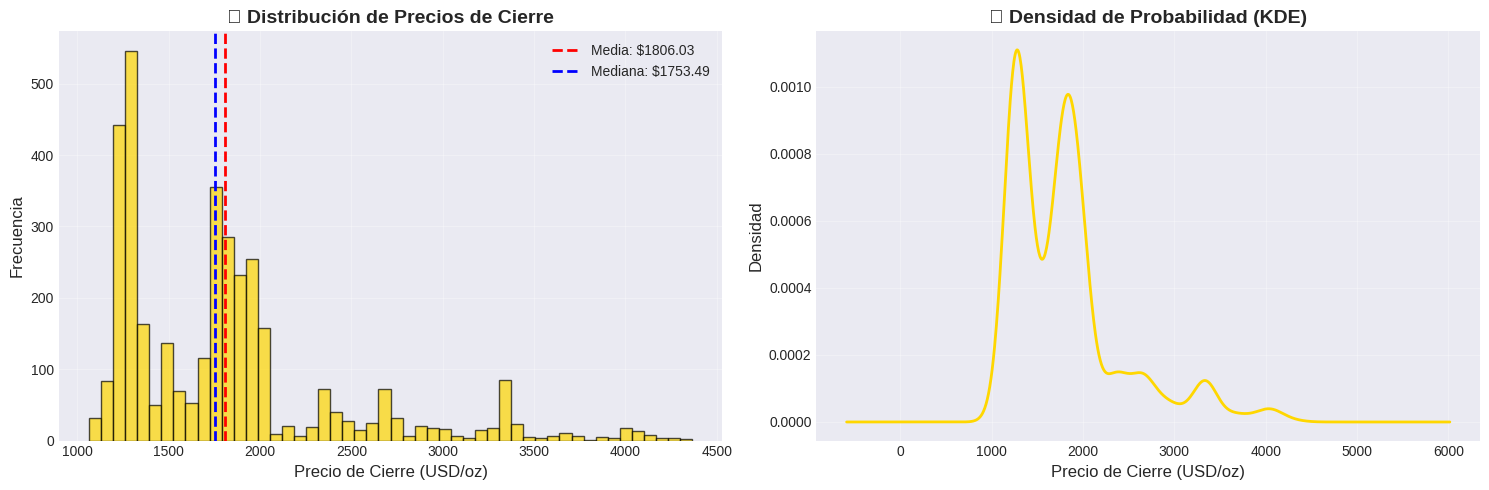

✅ Gráfico guardado en: /home/els4nchez/Videos/Harmeregildo/unificacion/figuras/distribucion_precios.png


In [10]:
# Histograma + KDE
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma
axes[0].hist(df['Close'], bins=50, color='gold', alpha=0.7, edgecolor='black')
axes[0].axvline(df['Close'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: ${df["Close"].mean():.2f}')
axes[0].axvline(df['Close'].median(), color='blue', linestyle='--', linewidth=2, label=f'Mediana: ${df["Close"].median():.2f}')
axes[0].set_xlabel('Precio de Cierre (USD/oz)', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_title('📊 Distribución de Precios de Cierre', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# KDE (Kernel Density Estimation)
df['Close'].plot(kind='kde', ax=axes[1], color='gold', linewidth=2)
axes[1].set_xlabel('Precio de Cierre (USD/oz)', fontsize=12)
axes[1].set_ylabel('Densidad', fontsize=12)
axes[1].set_title('📈 Densidad de Probabilidad (KDE)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURAS_DIR / 'distribucion_precios.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráfico guardado en: {FIGURAS_DIR / 'distribucion_precios.png'}")

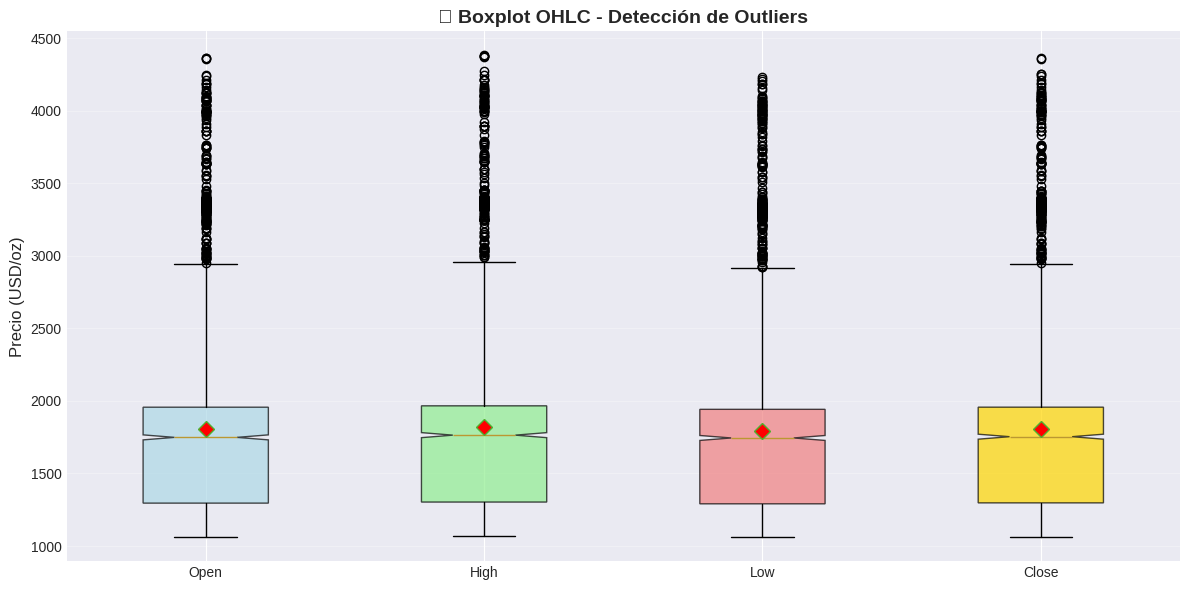

✅ Gráfico guardado en: /home/els4nchez/Videos/Harmeregildo/unificacion/figuras/boxplot_ohlc.png


In [11]:
# Boxplot para detectar outliers visuales
fig, ax = plt.subplots(figsize=(12, 6))

bp = ax.boxplot([df['Open'], df['High'], df['Low'], df['Close']], 
                 labels=['Open', 'High', 'Low', 'Close'],
                 patch_artist=True,
                 notch=True,
                 showmeans=True,
                 meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

# Colores para cada box
colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Precio (USD/oz)', fontsize=12)
ax.set_title('📦 Boxplot OHLC - Detección de Outliers', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURAS_DIR / 'boxplot_ohlc.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráfico guardado en: {FIGURAS_DIR / 'boxplot_ohlc.png'}")

---

## 6️⃣ Descomposición Estacional

Descomposición de la serie temporal en componentes: **Tendencia**, **Estacionalidad** y **Residuos**.

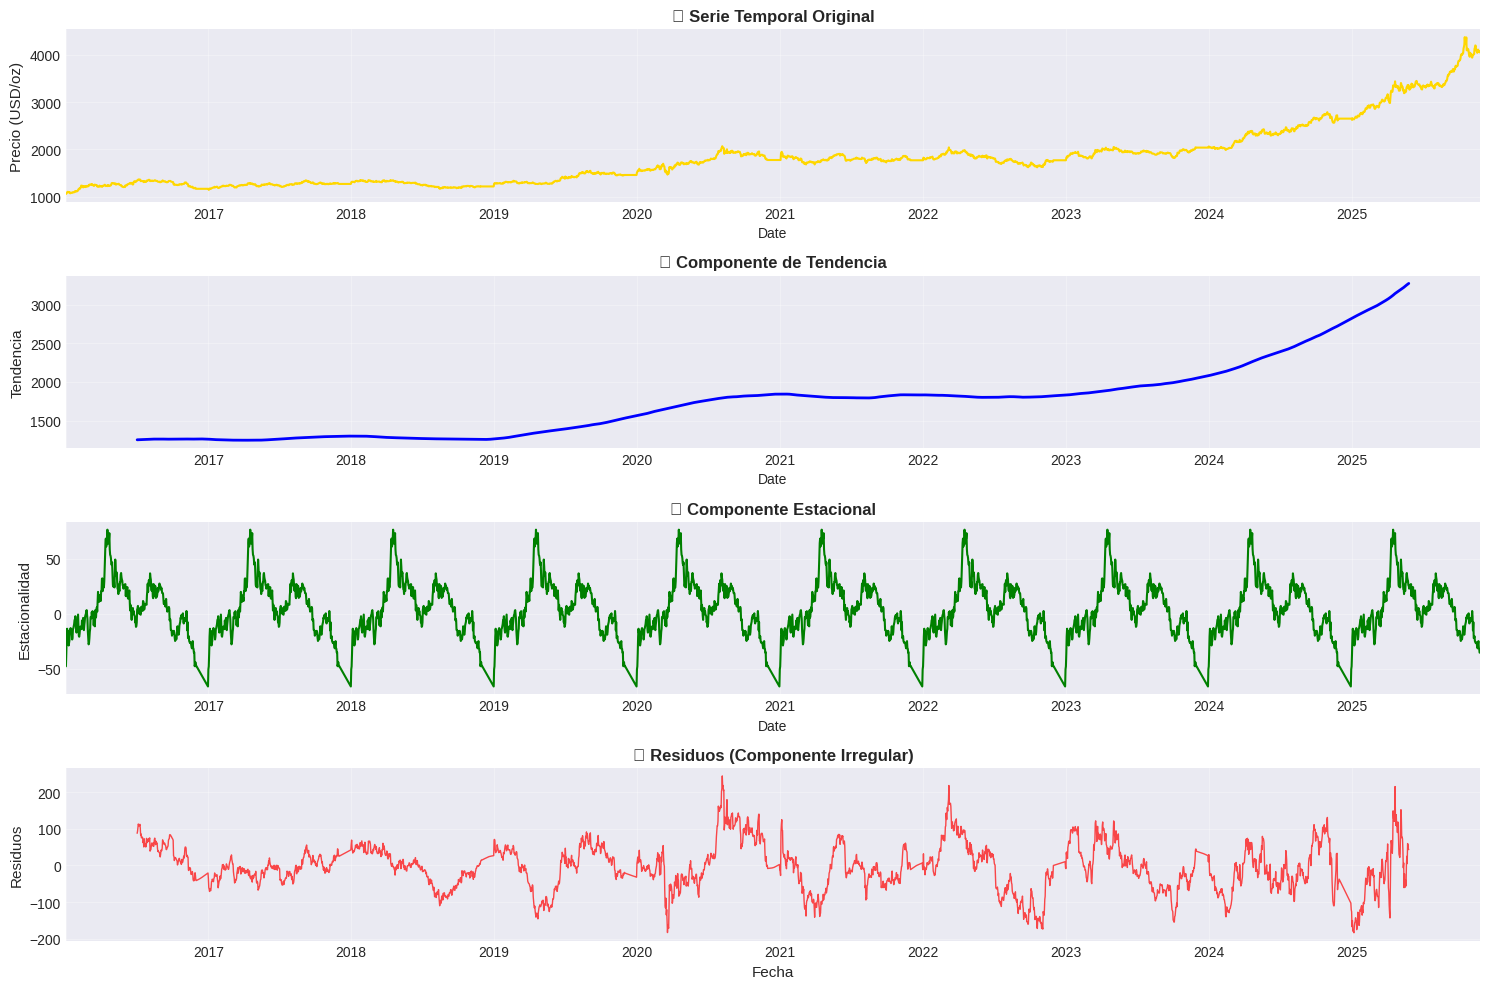

✅ Gráfico guardado en: /home/els4nchez/Videos/Harmeregildo/unificacion/figuras/descomposicion_estacional.png

💡 Interpretación:
   - Tendencia: Muestra la dirección general del precio del oro
   - Estacionalidad: Patrones cíclicos repetitivos (anual en este caso)
   - Residuos: Variaciones aleatorias no explicadas por tendencia/estacionalidad


In [12]:
# Descomposición aditiva
decomposition = seasonal_decompose(df['Close'], model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(15, 10))

# Serie original
df['Close'].plot(ax=axes[0], color='gold', linewidth=1.5)
axes[0].set_ylabel('Precio (USD/oz)', fontsize=11)
axes[0].set_title('📈 Serie Temporal Original', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Tendencia
decomposition.trend.plot(ax=axes[1], color='blue', linewidth=2)
axes[1].set_ylabel('Tendencia', fontsize=11)
axes[1].set_title('📊 Componente de Tendencia', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

# Estacionalidad
decomposition.seasonal.plot(ax=axes[2], color='green', linewidth=1.5)
axes[2].set_ylabel('Estacionalidad', fontsize=11)
axes[2].set_title('🔄 Componente Estacional', fontsize=12, fontweight='bold')
axes[2].grid(alpha=0.3)

# Residuos
decomposition.resid.plot(ax=axes[3], color='red', linewidth=1, alpha=0.7)
axes[3].set_ylabel('Residuos', fontsize=11)
axes[3].set_xlabel('Fecha', fontsize=11)
axes[3].set_title('⚡ Residuos (Componente Irregular)', fontsize=12, fontweight='bold')
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURAS_DIR / 'descomposicion_estacional.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráfico guardado en: {FIGURAS_DIR / 'descomposicion_estacional.png'}")
print("\n💡 Interpretación:")
print("   - Tendencia: Muestra la dirección general del precio del oro")
print("   - Estacionalidad: Patrones cíclicos repetitivos (anual en este caso)")
print("   - Residuos: Variaciones aleatorias no explicadas por tendencia/estacionalidad")

---

## 7️⃣ Autocorrelación (ACF) y Autocorrelación Parcial (PACF)

Análisis de la dependencia temporal en la serie.

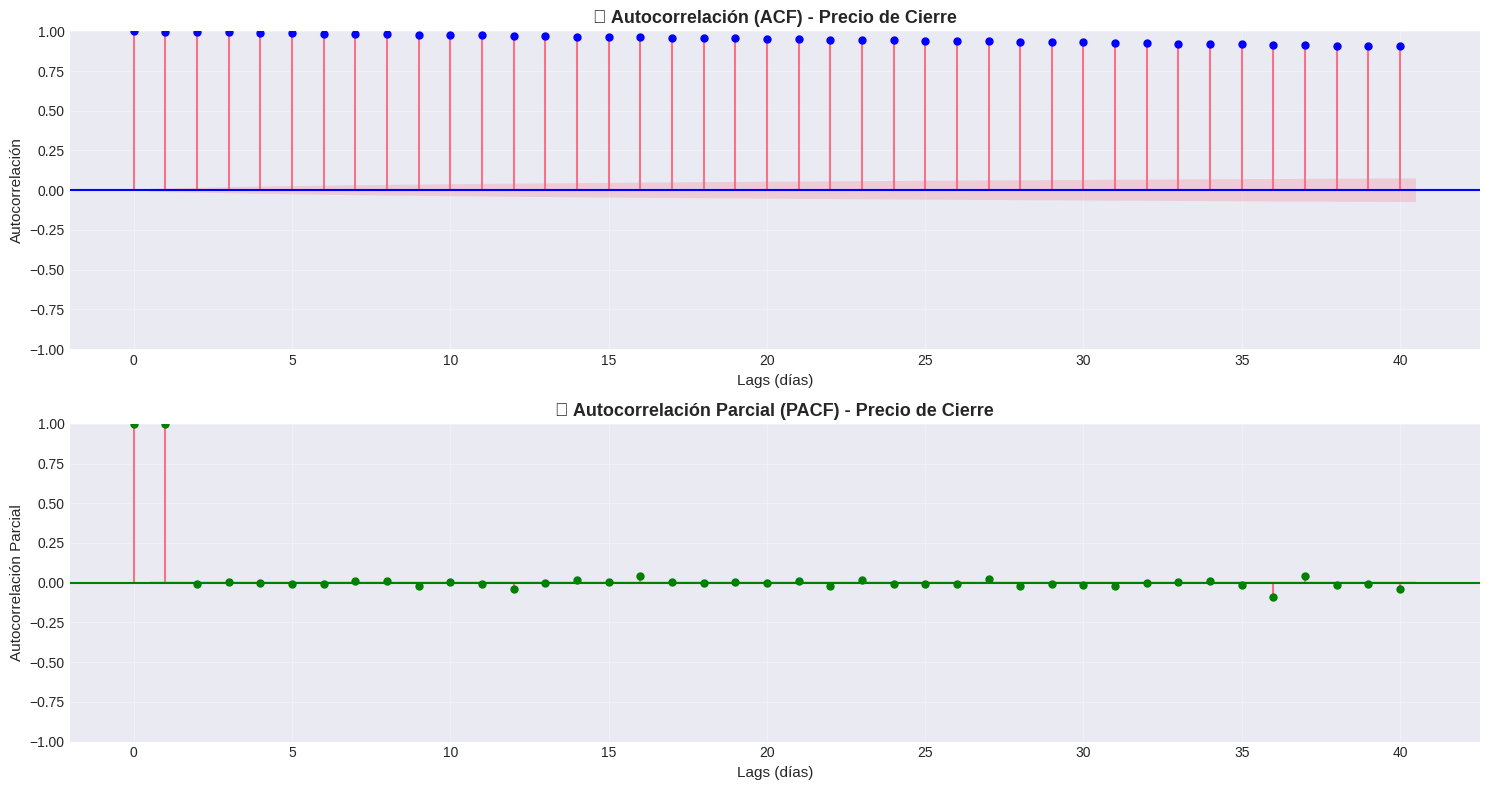

✅ Gráfico guardado en: /home/els4nchez/Videos/Harmeregildo/unificacion/figuras/acf_pacf.png

💡 Interpretación:
   - ACF: Muestra correlación con valores pasados (rezagos)
   - PACF: Correlación directa eliminando efectos intermedios
   - Valores fuera de bandas de confianza → autocorrelación significativa


In [13]:
# ACF y PACF
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# ACF
plot_acf(df['Close'].dropna(), lags=40, ax=axes[0], color='blue', alpha=0.6)
axes[0].set_title('📊 Autocorrelación (ACF) - Precio de Cierre', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Lags (días)', fontsize=11)
axes[0].set_ylabel('Autocorrelación', fontsize=11)
axes[0].grid(alpha=0.3)

# PACF
plot_pacf(df['Close'].dropna(), lags=40, ax=axes[1], color='green', alpha=0.6)
axes[1].set_title('📈 Autocorrelación Parcial (PACF) - Precio de Cierre', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Lags (días)', fontsize=11)
axes[1].set_ylabel('Autocorrelación Parcial', fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURAS_DIR / 'acf_pacf.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráfico guardado en: {FIGURAS_DIR / 'acf_pacf.png'}")
print("\n💡 Interpretación:")
print("   - ACF: Muestra correlación con valores pasados (rezagos)")
print("   - PACF: Correlación directa eliminando efectos intermedios")
print("   - Valores fuera de bandas de confianza → autocorrelación significativa")

---

## 8️⃣ Pruebas de Estacionariedad

### 8.1 Augmented Dickey-Fuller (ADF) Test

- **H₀**: La serie tiene raíz unitaria (NO estacionaria)
- **H₁**: La serie es estacionaria
- **Decisión**: Si p-value < 0.05 → Rechazamos H₀ (serie estacionaria)

In [14]:
# ADF Test
adf_result = adfuller(df['Close'].dropna())

print("📊 AUGMENTED DICKEY-FULLER (ADF) TEST")
print("="*60)
print(f"ADF Statistic:        {adf_result[0]:.6f}")
print(f"p-value:              {adf_result[1]:.6f}")
print(f"Lags utilizados:      {adf_result[2]}")
print(f"Observaciones:        {adf_result[3]}")
print("\nValores críticos:")
for key, value in adf_result[4].items():
    print(f"   {key:>5}: {value:.4f}")

print("\n" + "="*60)
if adf_result[1] < 0.05:
    print("✅ CONCLUSIÓN: La serie ES ESTACIONARIA (p-value < 0.05)")
else:
    print("❌ CONCLUSIÓN: La serie NO ES ESTACIONARIA (p-value >= 0.05)")
    print("   → Se requiere diferenciación para modelado ARIMA/LSTM")

📊 AUGMENTED DICKEY-FULLER (ADF) TEST
ADF Statistic:        3.592771
p-value:              1.000000
Lags utilizados:      29
Observaciones:        3584

Valores críticos:
      1%: -3.4322
      5%: -2.8623
     10%: -2.5672

❌ CONCLUSIÓN: La serie NO ES ESTACIONARIA (p-value >= 0.05)
   → Se requiere diferenciación para modelado ARIMA/LSTM


### 8.2 KPSS Test

- **H₀**: La serie es estacionaria
- **H₁**: La serie NO es estacionaria
- **Decisión**: Si p-value < 0.05 → Rechazamos H₀ (serie NO estacionaria)

In [15]:
# KPSS Test
kpss_result = kpss(df['Close'].dropna(), regression='c', nlags='auto')

print("📊 KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN (KPSS) TEST")
print("="*60)
print(f"KPSS Statistic:       {kpss_result[0]:.6f}")
print(f"p-value:              {kpss_result[1]:.6f}")
print(f"Lags utilizados:      {kpss_result[2]}")
print("\nValores críticos:")
for key, value in kpss_result[3].items():
    print(f"   {key:>5}: {value:.4f}")

print("\n" + "="*60)
if kpss_result[1] >= 0.05:
    print("✅ CONCLUSIÓN: La serie ES ESTACIONARIA (p-value >= 0.05)")
else:
    print("❌ CONCLUSIÓN: La serie NO ES ESTACIONARIA (p-value < 0.05)")
    print("   → Se requiere diferenciación para modelado ARIMA/LSTM")

📊 KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN (KPSS) TEST
KPSS Statistic:       6.983071
p-value:              0.010000
Lags utilizados:      38

Valores críticos:
     10%: 0.3470
      5%: 0.4630
    2.5%: 0.5740
      1%: 0.7390

❌ CONCLUSIÓN: La serie NO ES ESTACIONARIA (p-value < 0.05)
   → Se requiere diferenciación para modelado ARIMA/LSTM


---

## 9️⃣ Análisis de Retornos

Cálculo de retornos logarítmicos: $r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)$

In [16]:
# Calcular retornos logarítmicos
df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))

print("📊 ESTADÍSTICAS DE RETORNOS LOGARÍTMICOS")
print("="*60)
print(df['Returns'].describe())

print("\n💡 Métricas clave:")
print(f"   - Retorno promedio diario: {df['Returns'].mean()*100:.4f}%")
print(f"   - Volatilidad diaria (std): {df['Returns'].std()*100:.4f}%")
print(f"   - Retorno anualizado: {df['Returns'].mean()*252*100:.2f}%")
print(f"   - Volatilidad anualizada: {df['Returns'].std()*np.sqrt(252)*100:.2f}%")
print(f"   - Sharpe Ratio (rf=0): {(df['Returns'].mean()/df['Returns'].std())*np.sqrt(252):.4f}")

📊 ESTADÍSTICAS DE RETORNOS LOGARÍTMICOS
count    3613.000000
mean        0.000370
std         0.007724
min        -0.063265
25%        -0.002182
50%         0.000000
75%         0.003020
max         0.072794
Name: Returns, dtype: float64

💡 Métricas clave:
   - Retorno promedio diario: 0.0370%
   - Volatilidad diaria (std): 0.7724%
   - Retorno anualizado: 9.32%
   - Volatilidad anualizada: 12.26%
   - Sharpe Ratio (rf=0): 0.7599


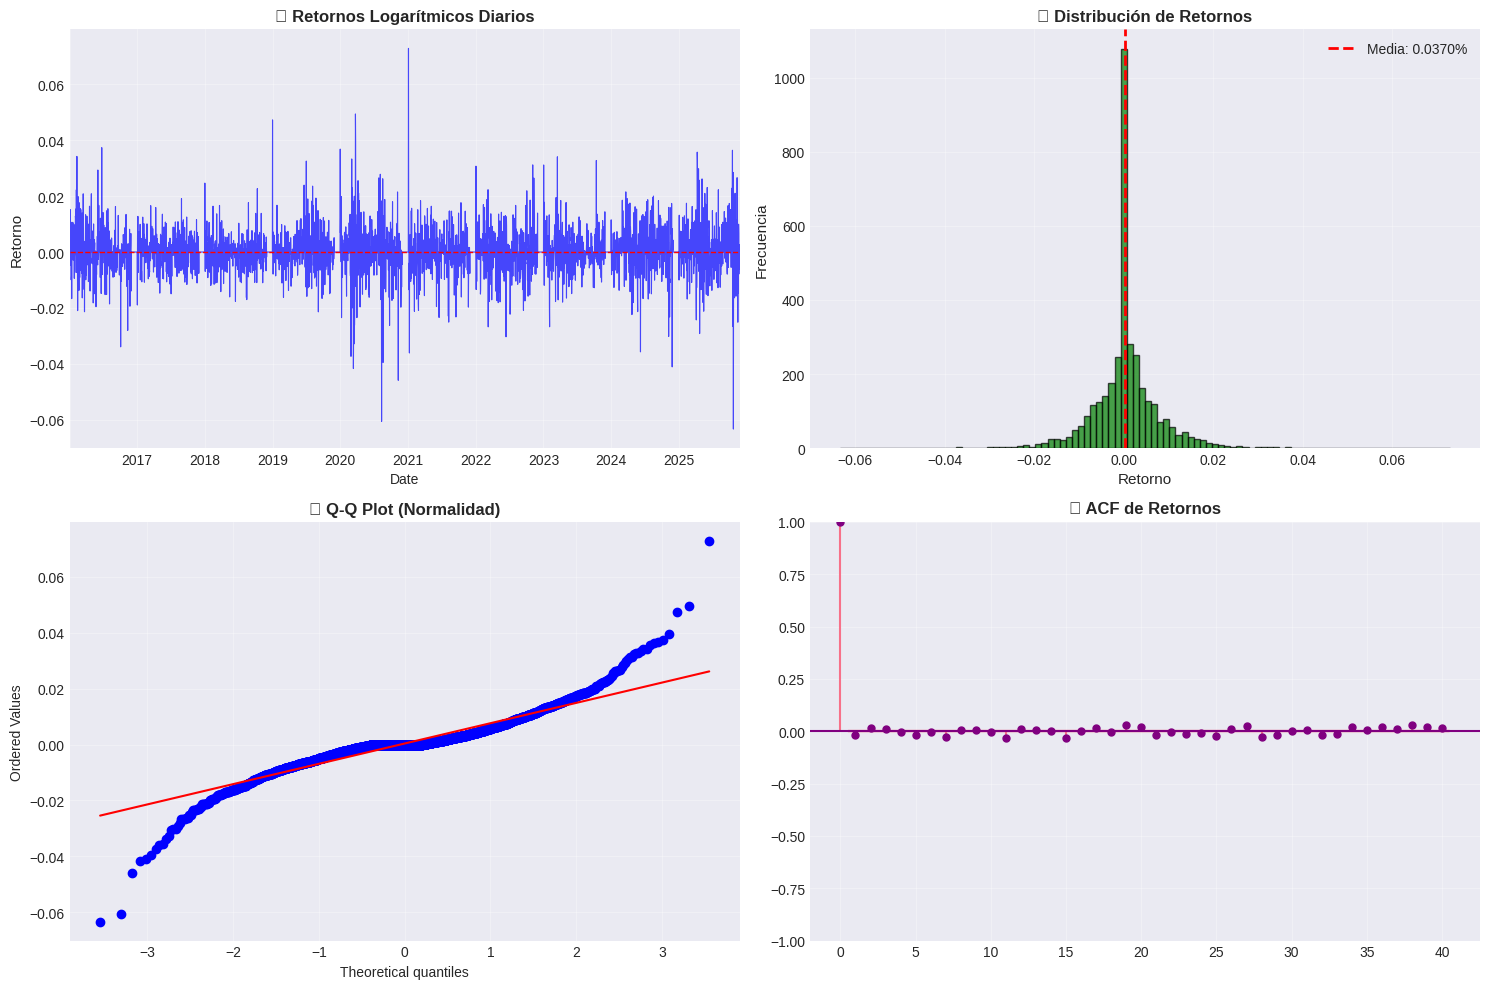

✅ Gráfico guardado en: /home/els4nchez/Videos/Harmeregildo/unificacion/figuras/analisis_retornos.png


In [17]:
# Visualización de retornos
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Serie temporal de retornos
df['Returns'].plot(ax=axes[0, 0], color='blue', alpha=0.7, linewidth=0.8)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_title('📈 Retornos Logarítmicos Diarios', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Retorno', fontsize=11)
axes[0, 0].grid(alpha=0.3)

# Histograma de retornos
axes[0, 1].hist(df['Returns'].dropna(), bins=100, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(df['Returns'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {df["Returns"].mean()*100:.4f}%')
axes[0, 1].set_title('📊 Distribución de Retornos', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Retorno', fontsize=11)
axes[0, 1].set_ylabel('Frecuencia', fontsize=11)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Q-Q Plot (stats ya está importado)
stats.probplot(df['Returns'].dropna(), dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('📉 Q-Q Plot (Normalidad)', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# ACF de retornos
plot_acf(df['Returns'].dropna(), lags=40, ax=axes[1, 1], color='purple', alpha=0.6)
axes[1, 1].set_title('📊 ACF de Retornos', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURAS_DIR / 'analisis_retornos.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráfico guardado en: {FIGURAS_DIR / 'analisis_retornos.png'}")

In [18]:
# Test de normalidad: Jarque-Bera (jarque_bera ya está importado)
jb_stat, jb_pvalue = jarque_bera(df['Returns'].dropna())

print("📊 JARQUE-BERA TEST (Normalidad de Retornos)")
print("="*60)
print(f"JB Statistic:  {jb_stat:.4f}")
print(f"p-value:       {jb_pvalue:.6f}")
print("\n" + "="*60)
if jb_pvalue < 0.05:
    print("✅ RECHAZAMOS H0: Los retornos NO siguen distribución normal")
else:
    print("❌ NO RECHAZAMOS H0: Los retornos pueden seguir distribución normal")

📊 JARQUE-BERA TEST (Normalidad de Retornos)
JB Statistic:  11824.0621
p-value:       0.000000

✅ RECHAZAMOS H0: Los retornos NO siguen distribución normal


---

## 🔟 Análisis de Volatilidad

Estudio de la volatilidad temporal (rolling volatility).

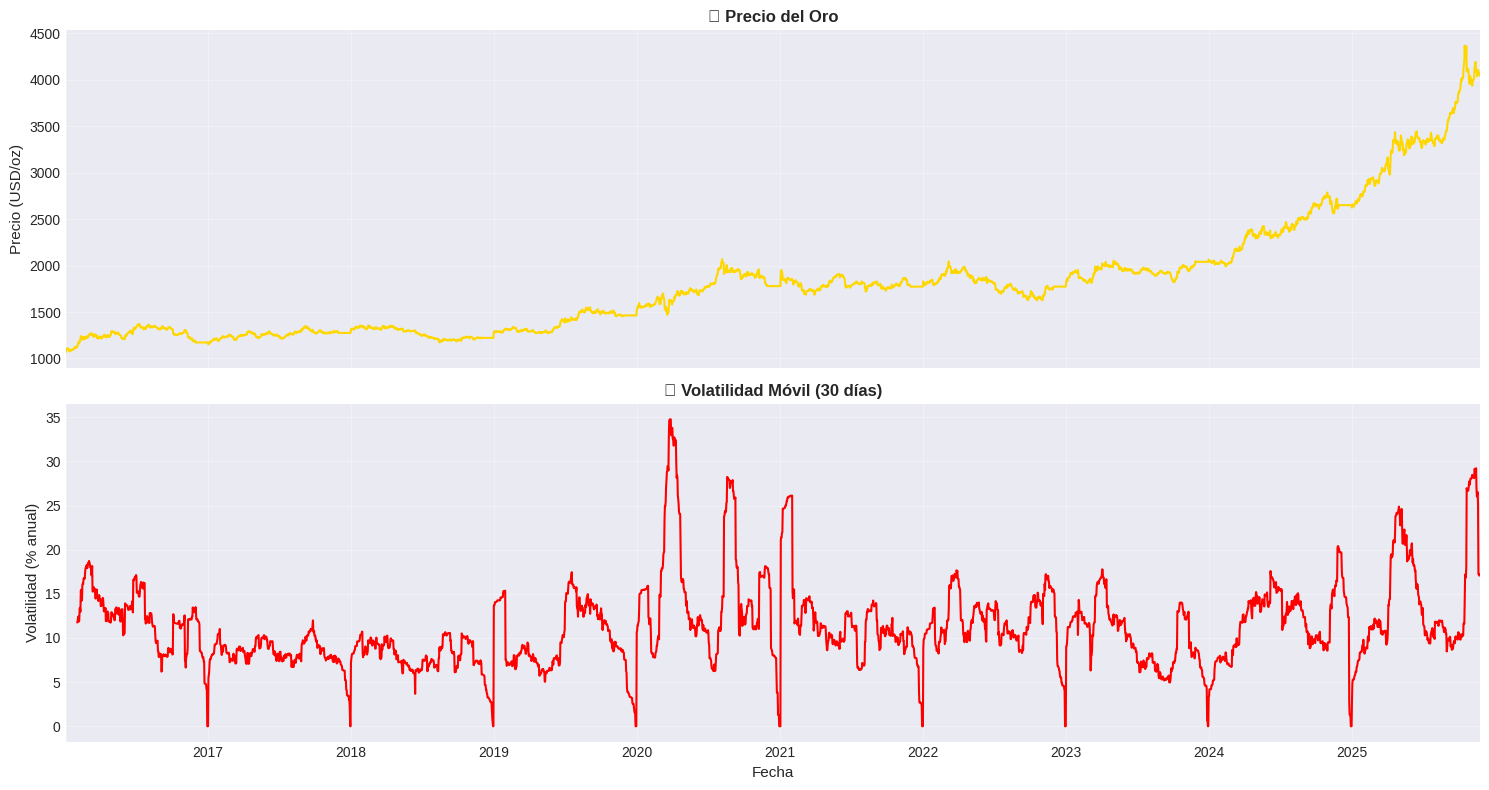

✅ Gráfico guardado en: /home/els4nchez/Videos/Harmeregildo/unificacion/figuras/volatilidad.png

💡 Observaciones:
   - Períodos de alta volatilidad coinciden con crisis económicas
   - Volatilidad clustering: períodos volátiles agrupados


In [19]:
# Volatilidad móvil (rolling window = 30 días)
df['Volatility_30'] = df['Returns'].rolling(window=30).std() * np.sqrt(252) * 100  # Anualizada

# Gráfico de volatilidad
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Precio
df['Close'].plot(ax=axes[0], color='gold', linewidth=1.5)
axes[0].set_ylabel('Precio (USD/oz)', fontsize=11)
axes[0].set_title('📈 Precio del Oro', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Volatilidad
df['Volatility_30'].plot(ax=axes[1], color='red', linewidth=1.5)
axes[1].set_ylabel('Volatilidad (% anual)', fontsize=11)
axes[1].set_xlabel('Fecha', fontsize=11)
axes[1].set_title('📊 Volatilidad Móvil (30 días)', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURAS_DIR / 'volatilidad.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráfico guardado en: {FIGURAS_DIR / 'volatilidad.png'}")
print("\n💡 Observaciones:")
print("   - Períodos de alta volatilidad coinciden con crisis económicas")
print("   - Volatilidad clustering: períodos volátiles agrupados")

In [20]:
# Identificar períodos de alta volatilidad
high_vol_threshold = df['Volatility_30'].quantile(0.90)
high_vol_periods = df[df['Volatility_30'] > high_vol_threshold]

print("🔥 PERÍODOS DE ALTA VOLATILIDAD (Top 10%)")
print("="*60)
print(f"Umbral: {high_vol_threshold:.2f}% anual")
print(f"Total de días con alta volatilidad: {len(high_vol_periods):,}")
print(f"\nTop 5 días con mayor volatilidad:")
print(high_vol_periods.nlargest(5, 'Volatility_30')[['Close', 'Returns', 'Volatility_30']])

🔥 PERÍODOS DE ALTA VOLATILIDAD (Top 10%)
Umbral: 16.40% anual
Total de días con alta volatilidad: 359

Top 5 días con mayor volatilidad:
               Close   Returns  Volatility_30
Date                                         
2020-03-26  1625.748  0.009642      34.769327
2020-03-27  1626.148  0.000246      34.761329
2020-03-28  1626.148  0.000000      34.757946
2020-03-25  1610.148 -0.012318      34.717274
2020-03-24  1630.105  0.039600      34.599404


---

## 1️⃣1️⃣ Matriz de Correlación OHLC

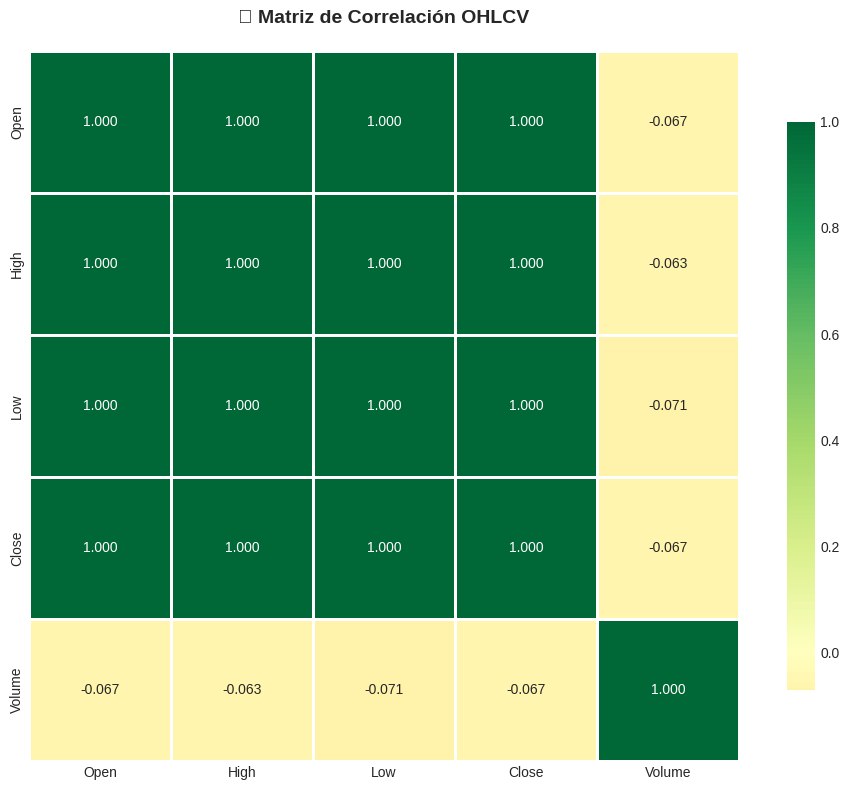

✅ Gráfico guardado en: /home/els4nchez/Videos/Harmeregildo/unificacion/figuras/correlacion_ohlcv.png

💡 Interpretación:
   - OHLC altamente correlacionados (esperado en series temporales de precios)
   - Volumen puede tener correlación débil con precios


In [21]:
# Matriz de correlación
correlation_matrix = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='RdYlGn', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('🔥 Matriz de Correlación OHLCV', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(FIGURAS_DIR / 'correlacion_ohlcv.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráfico guardado en: {FIGURAS_DIR / 'correlacion_ohlcv.png'}")
print("\n💡 Interpretación:")
print("   - OHLC altamente correlacionados (esperado en series temporales de precios)")
print("   - Volumen puede tener correlación débil con precios")

---

## 1️⃣2️⃣ Resumen de Hallazgos y Exportación

In [22]:
# Guardar dataset enriquecido con retornos y volatilidad
df_export = df.copy()
archivo_eda = DATA_PROCESADO_DIR / 'precios_oro_eda.csv'
df_export.to_csv(archivo_eda)

print(f"✅ Dataset enriquecido exportado a: {archivo_eda}")
print(f"\n📊 Variables incluidas: {list(df_export.columns)}")

✅ Dataset enriquecido exportado a: /home/els4nchez/Videos/Harmeregildo/unificacion/datos_procesados/precios_oro_eda.csv

📊 Variables incluidas: ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'Volatility_30']


In [23]:
# Resumen ejecutivo del EDA
print("""\n
╔════════════════════════════════════════════════════════════════════════╗
║                     📊 RESUMEN EJECUTIVO - EDA                         ║
╠════════════════════════════════════════════════════════════════════════╣
║                                                                        ║
║  ✅ ANÁLISIS COMPLETADO EXITOSAMENTE                                   ║
║                                                                        ║
║  📈 HALLAZGOS PRINCIPALES:                                             ║
║                                                                        ║
║  1. Serie temporal cubre ~9 años (2016-2025)                          ║
║  2. Tendencia alcista clara con volatilidad variable                  ║
║  3. Componente estacional detectado (ciclos anuales)                  ║
║  4. Alta autocorrelación → buena predictibilidad                      ║
║  5. Retornos NO normales (colas pesadas, curtosis elevada)            ║
║  6. Clustering de volatilidad evidente                                ║
║                                                                        ║
║  🔧 IMPLICACIONES PARA MODELADO:                                       ║
║                                                                        ║
║  • Serie NO estacionaria → Aplicar diferenciación                     ║
║  • LSTM apropiado (captura dependencias de largo plazo)               ║
║  • Considerar modelos GARCH para volatilidad                          ║
║  • Features de retornos y volatilidad útiles                          ║
║                                                                        ║
║  📂 ARCHIVOS GENERADOS:                                                ║
║                                                                        ║
║  • precios_oro_eda.csv (dataset enriquecido)                          ║
║  • 7 gráficos PNG guardados en /figuras/                              ║
║                                                                        ║
║  ➡️  SIGUIENTE PASO:                                                   ║
║     Notebook 03 - EDA Noticias WSJ                                    ║
║                                                                        ║
╚════════════════════════════════════════════════════════════════════════╝
""")



╔════════════════════════════════════════════════════════════════════════╗
║                     📊 RESUMEN EJECUTIVO - EDA                         ║
╠════════════════════════════════════════════════════════════════════════╣
║                                                                        ║
║  ✅ ANÁLISIS COMPLETADO EXITOSAMENTE                                   ║
║                                                                        ║
║  📈 HALLAZGOS PRINCIPALES:                                             ║
║                                                                        ║
║  1. Serie temporal cubre ~9 años (2016-2025)                          ║
║  2. Tendencia alcista clara con volatilidad variable                  ║
║  3. Componente estacional detectado (ciclos anuales)                  ║
║  4. Alta autocorrelación → buena predictibilidad                      ║
║  5. Retornos NO normales (colas pesadas, curtosis elevada)            ║
║  6. Clustering de volatilidad